In this notebook, we use our feasibility models to evaluate the feasibility scores of our previously published propionic acid pathways.

In [4]:
from featurizations import featurizations
import pickle
import pandas as pd
import numpy as np
from ML_utils import ML_utils
import json
import networkx as nx
import copy

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500 # Resolution of figures
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.loc"] = 'best'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [6]:
def product_of_list(numbers):
    product = 1.0
    for number in numbers:
        product *= number
    return product

In [7]:
by_desc_MW_model_filepath = '../../models/consolidated_models/all_BKM_rxns_ecfp4_XGBoost_4_by_descending_MW.pkl'
by_desc_MW_model_threshold_filepath = '../../models/thresholds/all_BKM_rxns_ecfp4_XGBoost_4_by_descending_MW_feasibility_threshold.txt'

with open(by_desc_MW_model_filepath, 'rb') as file:
    by_desc_MW_model = pickle.load(file)
    
by_desc_MW_model_threshold = float(np.loadtxt(by_desc_MW_model_threshold_filepath))

In [8]:
by_asc_MW_model_filepath = '../../models/consolidated_models/all_BKM_rxns_ecfp4_XGBoost_4_by_ascending_MW.pkl'
by_asc_MW_model_threshold_filepath = '../../models/thresholds/all_BKM_rxns_ecfp4_XGBoost_4_by_ascending_MW_feasibility_threshold.txt'

with open(by_asc_MW_model_filepath, 'rb') as file:
    by_asc_MW_model = pickle.load(file)
    
by_asc_MW_model_threshold = float(np.loadtxt(by_asc_MW_model_threshold_filepath))

In [9]:
add_concat_model_filepath = '../../models/consolidated_models/all_BKM_rxns_ecfp4_XGBoost_4_add_concat.pkl'
add_concat_model_threshold_filepath = '../../models/thresholds/all_BKM_rxns_ecfp4_XGBoost_4_add_concat_feasibility_threshold.txt'

with open(add_concat_model_filepath, 'rb') as file:
    add_concat_model = pickle.load(file)
    
add_concat_model_threshold = float(np.loadtxt(add_concat_model_threshold_filepath))

In [10]:
add_subtract_model_filepath = '../../models/consolidated_models/all_BKM_rxns_ecfp4_XGBoost_4_add_subtract.pkl'
add_subtract_model_threshold_filepath = '../../models/thresholds/all_BKM_rxns_ecfp4_XGBoost_4_add_subtract_feasibility_threshold.txt'

with open(add_subtract_model_filepath, 'rb') as file:
    add_subtract_model = pickle.load(file)
    
add_subtract_model_threshold = float(np.loadtxt(add_subtract_model_threshold_filepath))

In [11]:
all_cofactors_wo_stereo_filepath = '../../data/processed/expanded_cofactors_no_stereochem.tsv'
cofactors_df = pd.read_csv(all_cofactors_wo_stereo_filepath, delimiter=',')
all_cofactors_wo_stereo = set(cofactors_df['SMILES'])

In [12]:
def calculate_proba(rxn_str, all_cofactors_wo_stereo):
    
    rxn_obj = featurizations.reaction(rxn_str)
    
    by_desc_MW_fp = rxn_obj.rxn_2_fp_w_positioning(fp_type = 'ecfp4', 
                                                   cofactor_positioning = 'by_descending_MW',
                                                   all_cofactors_wo_stereo = all_cofactors_wo_stereo)
    
    by_asc_MW_fp = rxn_obj.rxn_2_fp_w_positioning(fp_type = 'ecfp4', 
                                                  cofactor_positioning = 'by_ascending_MW',
                                                  all_cofactors_wo_stereo = all_cofactors_wo_stereo)
    
    add_concat_fp = rxn_obj.rxn_2_fp_w_positioning(fp_type = 'ecfp4', 
                                                   cofactor_positioning = 'add_concat',
                                                   all_cofactors_wo_stereo = all_cofactors_wo_stereo)
    
    add_subtract_fp = rxn_obj.rxn_2_fp_w_positioning(fp_type = 'ecfp4', 
                                                   cofactor_positioning = 'add_subtract',
                                                   all_cofactors_wo_stereo = all_cofactors_wo_stereo)
    
    # reshape since only single sample
    by_desc_MW_fp = by_desc_MW_fp.reshape(1, -1)  
    by_asc_MW_fp = by_asc_MW_fp.reshape(1, -1)
    add_concat_fp = add_concat_fp.reshape(1, -1)
    add_subtract_fp = add_subtract_fp.reshape(1, -1)
    
    feasib_score_by_desc_MW = by_desc_MW_model.predict_proba(by_desc_MW_fp)[:,1][0]
    feasib_score_by_asc_MW = by_asc_MW_model.predict_proba(by_asc_MW_fp)[:,1][0]
    feasib_score_add_concat = add_concat_model.predict_proba(add_concat_fp)[:,1][0]
    feasib_score_add_subtract = add_subtract_model.predict_proba(add_subtract_fp)[:,1][0]
    
    feasib_label_by_desc_MW = 0
    feasib_label_by_asc_MW = 0
    feasib_label_add_concat = 0
    feasib_label_add_subtract = 0
    
    if feasib_score_by_desc_MW >= by_desc_MW_model_threshold:
        feasib_label_by_desc_MW += 1
    
    if feasib_score_by_asc_MW >= by_asc_MW_model_threshold:
        feasib_label_by_asc_MW +=1
        
    if feasib_score_add_concat >= add_concat_model_threshold:
        feasib_label_add_concat += 1
        
    if feasib_score_add_subtract >= add_subtract_model_threshold:
        feasib_label_add_subtract += 1
    
    print(f'Feasibility score with descending MW model: {feasib_score_by_desc_MW: .3f}, predicted label: {feasib_label_by_desc_MW}')
    print(f'Feasibility score with ascending MW model: {feasib_score_by_asc_MW: .3f}, predicted label: {feasib_label_by_asc_MW}')
    print(f'Feasibility score with add concat model: {feasib_score_add_concat: .3f}, predicted label: {feasib_label_add_concat}')
    print(f'Feasibility score with add subtract model: {feasib_score_add_subtract: .3f}, predicted label: {feasib_label_add_subtract}')

Pyruvic acid to Malic acid (r1)

In [13]:
rxn_str = "OC(C(C)=O)=O + O=C=O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 + OC(C(O)CC(O)=O)=O"
calculate_proba(rxn_str, all_cofactors_wo_stereo)

Feasibility score with descending MW model:  0.928, predicted label: 1
Feasibility score with ascending MW model:  0.983, predicted label: 1
Feasibility score with add concat model:  0.793, predicted label: 1
Feasibility score with add subtract model:  0.936, predicted label: 1


Pyruvic acid to Lactic acid (r2)

In [14]:
rxn_str = "OC(C(C)=O)=O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 + O=C(O)C(C)O"
calculate_proba(rxn_str, all_cofactors_wo_stereo)

Feasibility score with descending MW model:  0.994, predicted label: 1
Feasibility score with ascending MW model:  0.997, predicted label: 1
Feasibility score with add concat model:  0.994, predicted label: 1
Feasibility score with add subtract model:  0.995, predicted label: 1


Pyruvic acid to Acetyldehyde (r3)

In [16]:
rxn_str = "OC(C(C)=O)=O = CC=O + O=C=O"
calculate_proba(rxn_str, all_cofactors_wo_stereo)

Feasibility score with descending MW model:  0.997, predicted label: 1
Feasibility score with ascending MW model:  1.000, predicted label: 1
Feasibility score with add concat model:  0.996, predicted label: 1
Feasibility score with add subtract model:  0.992, predicted label: 1


Pyruvic acid to Alanine (r4)

In [17]:
rxn_str = "OC(C(C)=O)=O + N + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1 = O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 + O=C(O)C(C)N"
calculate_proba(rxn_str, all_cofactors_wo_stereo)

Feasibility score with descending MW model:  0.919, predicted label: 1
Feasibility score with ascending MW model:  0.989, predicted label: 1
Feasibility score with add concat model:  0.989, predicted label: 1
Feasibility score with add subtract model:  0.994, predicted label: 1


Malic acid to Fumaric acid (r5)

In [14]:
rxn_str = "OC(C(CC(O)=O)O)=O = O + OC(C=CC(O)=O)=O"
calculate_proba(rxn_str, all_cofactors_wo_stereo)b

Feasibility score with descending MW model:  0.936, predicted label: 1
Feasibility score with ascending MW model:  0.927, predicted label: 1
Feasibility score with add concat model:  0.867, predicted label: 1
Feasibility score with add subtract model:  0.900, predicted label: 1


Malic acid to 3-hydroxypyruvic acid (r6)

In [15]:
rxn_str = "OC(C(CC(O)=O)O)=O = O=C=O + OCCC(O)=O"
calculate_proba(rxn_str, all_cofactors_wo_stereo)

Feasibility score with descending MW model:  0.837, predicted label: 1
Feasibility score with ascending MW model:  0.341, predicted label: 0
Feasibility score with add concat model:  0.492, predicted label: 0
Feasibility score with add subtract model:  0.156, predicted label: 0


Lactic acid to 3-hydroxypyruvic acid (r7)

In [16]:
rxn_str = "O=C(C(O)C)O = OCCC(O)=O"
calculate_proba(rxn_str, all_cofactors_wo_stereo)

Feasibility score with descending MW model:  0.585, predicted label: 1
Feasibility score with ascending MW model:  0.416, predicted label: 0
Feasibility score with add concat model:  0.316, predicted label: 0
Feasibility score with add subtract model:  0.114, predicted label: 0


Acetyldehyde to 3-hydroxypyruvic acid (r8)

In [17]:
rxn_str = "O=C=O + CC=O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 + OCCC(O)=O"
calculate_proba(rxn_str, all_cofactors_wo_stereo)

Feasibility score with descending MW model:  0.976, predicted label: 1
Feasibility score with ascending MW model:  0.053, predicted label: 0
Feasibility score with add concat model:  0.904, predicted label: 1
Feasibility score with add subtract model:  0.496, predicted label: 0


Alanine to beta-alanine (r9)

In [18]:
rxn_str = "O=C(O)C(C)N = O=C(CCN)O"
calculate_proba(rxn_str, all_cofactors_wo_stereo)

Feasibility score with descending MW model:  0.938, predicted label: 1
Feasibility score with ascending MW model:  0.852, predicted label: 1
Feasibility score with add concat model:  0.966, predicted label: 1
Feasibility score with add subtract model:  0.983, predicted label: 1


Fumaric acid to Acrylic acid (r10)

In [19]:
rxn_str = "OC(C=CC(O)=O)=O = O=C=O + C=CC(O)=O"
calculate_proba(rxn_str, all_cofactors_wo_stereo)

Feasibility score with descending MW model:  0.995, predicted label: 1
Feasibility score with ascending MW model:  0.997, predicted label: 1
Feasibility score with add concat model:  0.954, predicted label: 1
Feasibility score with add subtract model:  0.967, predicted label: 1


3-Hydroxypyruvic acid to acrylic acid (r11)

In [20]:
rxn_str = "OCCC(O)=O = O + C=CC(O)=O"
calculate_proba(rxn_str, all_cofactors_wo_stereo)

Feasibility score with descending MW model:  0.973, predicted label: 1
Feasibility score with ascending MW model:  0.964, predicted label: 1
Feasibility score with add concat model:  0.968, predicted label: 1
Feasibility score with add subtract model:  0.913, predicted label: 1


beta alanine to acrylic acid (r12)

In [21]:
rxn_str = "O=C(CCN)O = C=CC(O)=O + N"
calculate_proba(rxn_str, all_cofactors_wo_stereo)

Feasibility score with descending MW model:  0.956, predicted label: 1
Feasibility score with ascending MW model:  0.851, predicted label: 1
Feasibility score with add concat model:  0.887, predicted label: 1
Feasibility score with add subtract model:  0.916, predicted label: 1


Acrylic acid to Propionic acid (r13)

In [22]:
rxn_str = "C=CC(O)=O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 + CCC(O)=O"
calculate_proba(rxn_str, all_cofactors_wo_stereo)

Feasibility score with descending MW model:  0.990, predicted label: 1
Feasibility score with ascending MW model:  0.998, predicted label: 1
Feasibility score with add concat model:  0.980, predicted label: 1
Feasibility score with add subtract model:  0.993, predicted label: 1


In [23]:
# pathway 1 (r1, r5, r10, r13)
pathway_1_feasibility_scores_list = [0.793, 0.867, 0.954, 0.980]
pathway_1_net_feasibility = product_of_list(pathway_1_feasibility_scores_list)

# pathway 2 (r1, r6, r11, r13)
pathway_2_feasibility_scores_list = [0.793, 0.492, 0.968, 0.980]
pathway_2_net_feasibility = product_of_list(pathway_2_feasibility_scores_list)

# pathway 3 (r2, r7, r11, r13)
pathway_3_feasibility_scores_list = [0.994, 0.316, 0.968, 0.980]
pathway_3_net_feasibility = product_of_list(pathway_3_feasibility_scores_list)

# pathway 4 (r3, r8, r11, r13)
pathway_4_feasibility_scores_list = [0.996, 0.904, 0.968, 0.980]
pathway_4_net_feasibility = product_of_list(pathway_4_feasibility_scores_list)

# pathway 5 (r4, r9, r12, r13)
pathway_5_feasibility_scores_list = [0.989, 0.966, 0.887, 0.980]
pathway_5_net_feasibility = product_of_list(pathway_5_feasibility_scores_list)

In [24]:
pathway_1_net_feasibility

0.64278648252

In [25]:
pathway_2_net_feasibility

0.37011758784

In [26]:
pathway_3_net_feasibility

0.29797161856

In [27]:
pathway_4_net_feasibility

0.85414027776

In [28]:
pathway_5_net_feasibility

0.8304684032399999

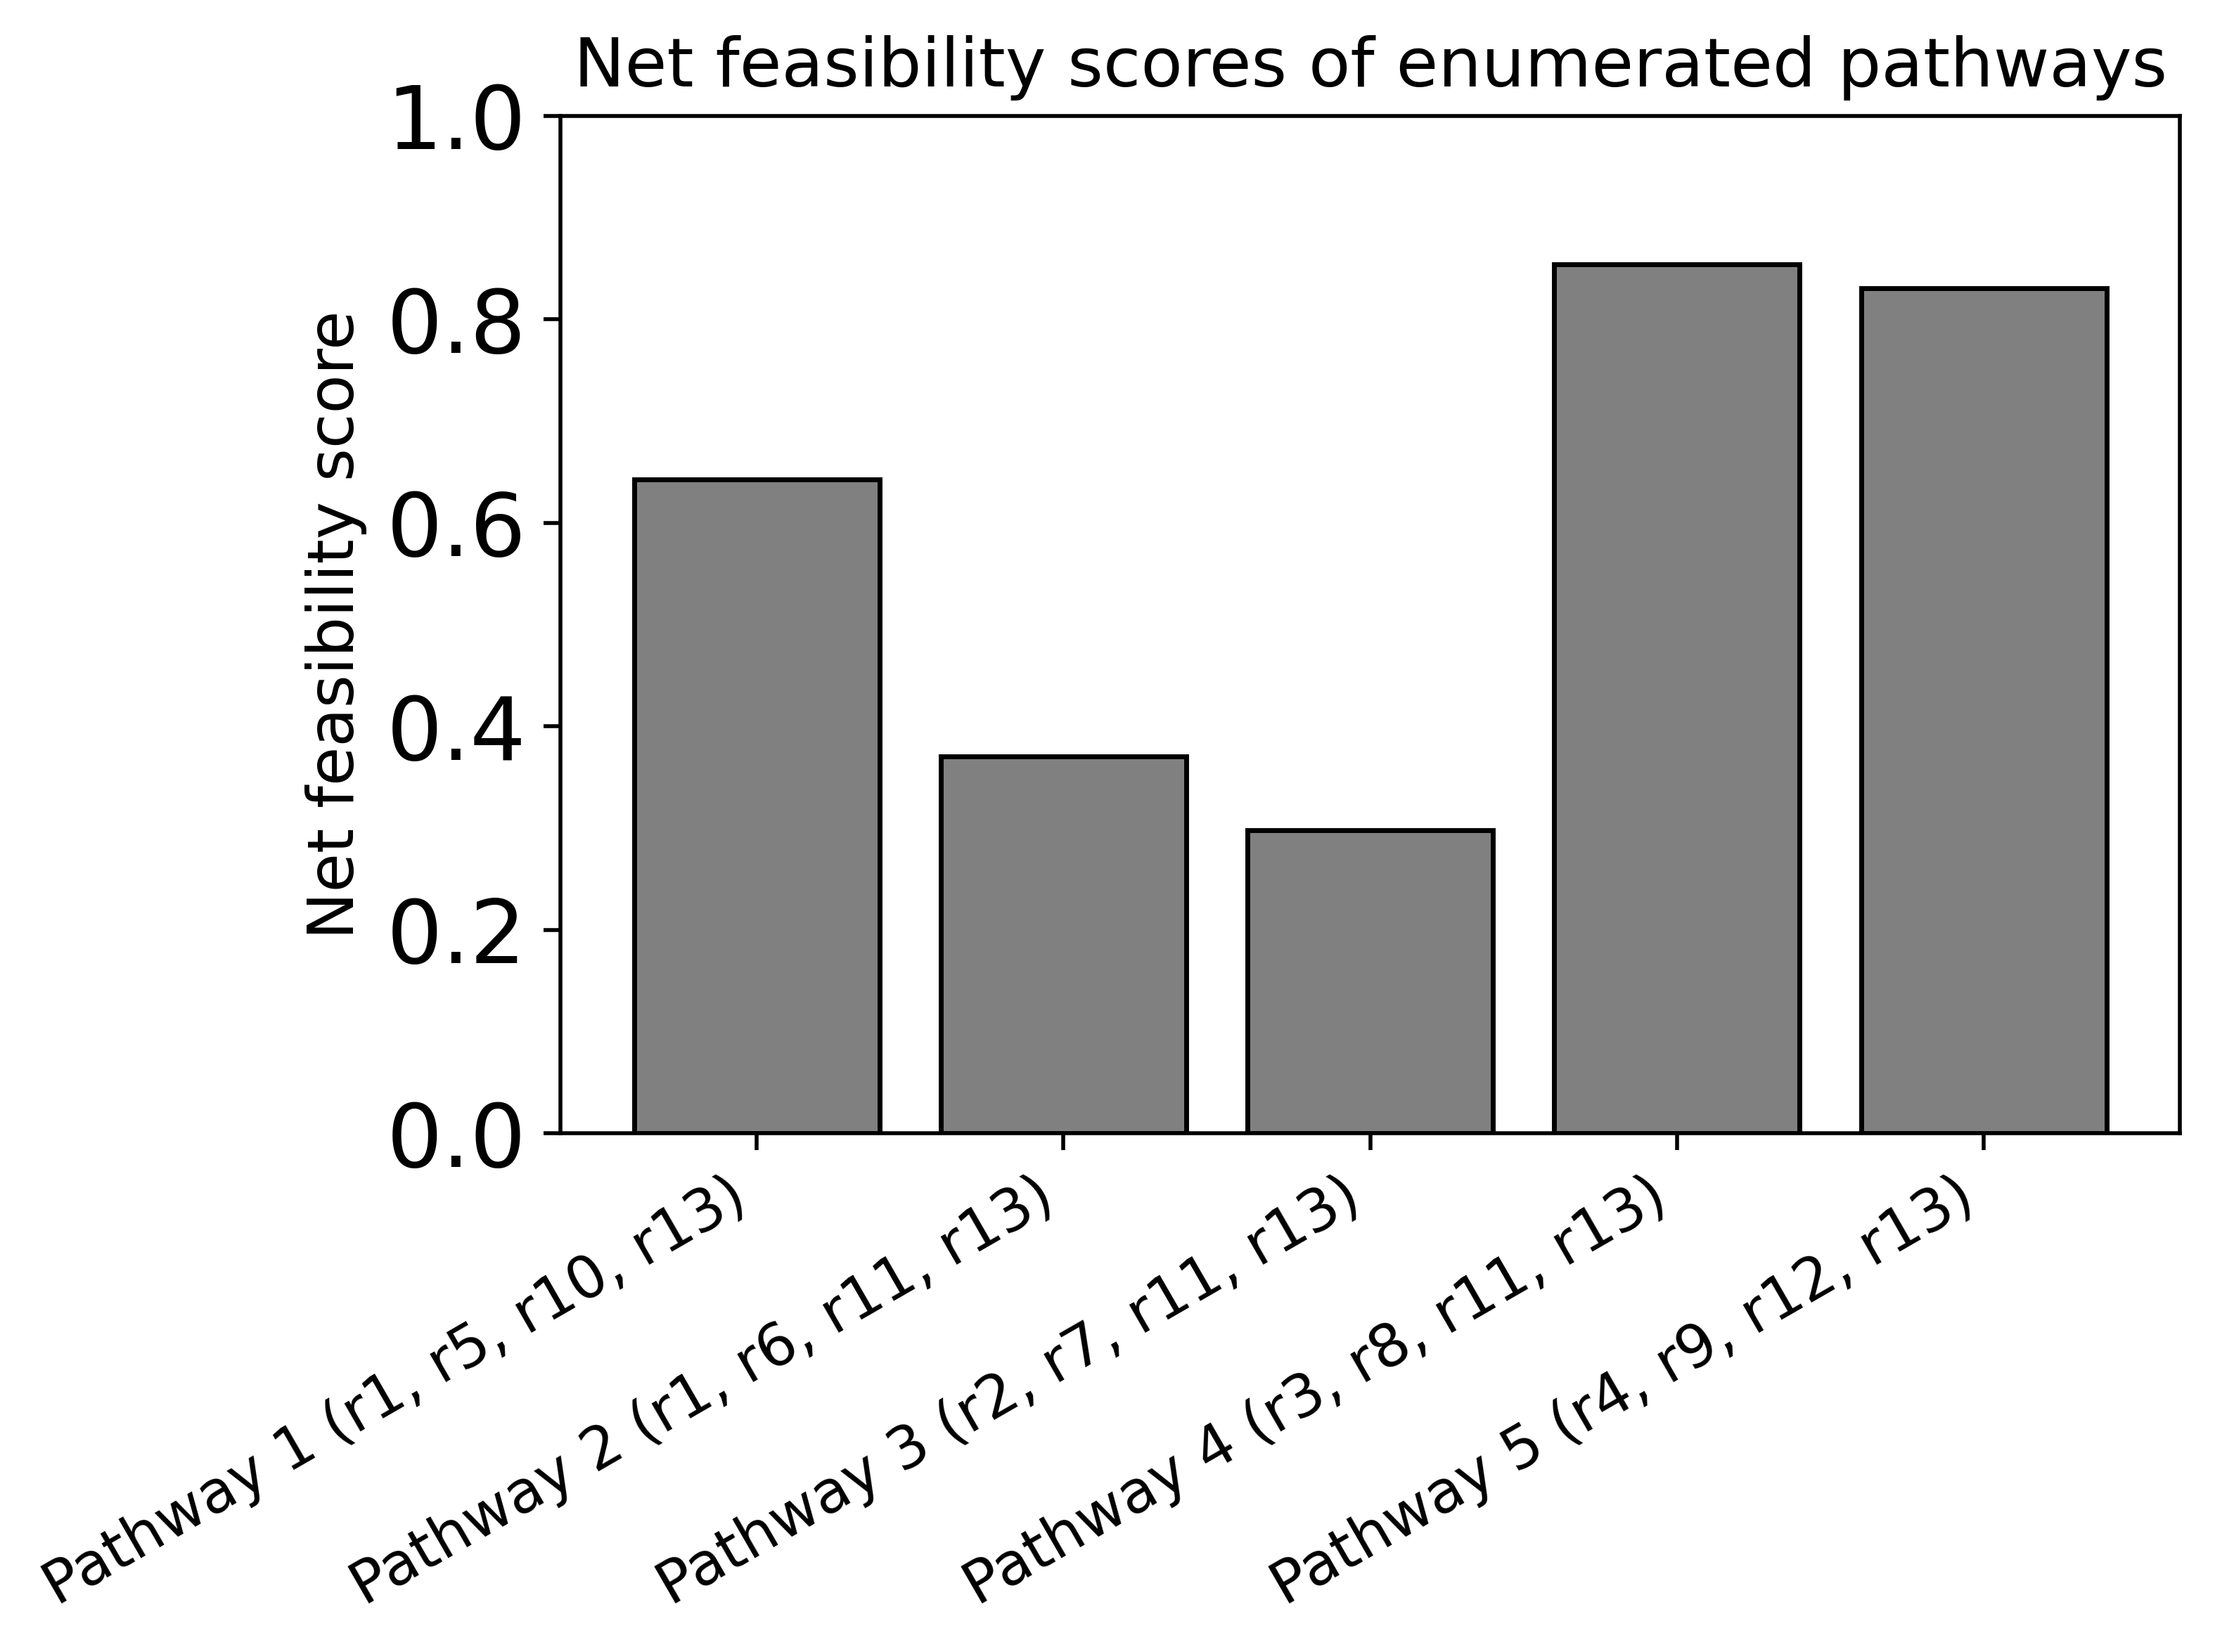

In [29]:
pathways = ['Pathway 1 (r1, r5, r10, r13)', 
            'Pathway 2 (r1, r6, r11, r13)', 
            'Pathway 3 (r2, r7, r11, r13)', 
            'Pathway 4 (r3, r8, r11, r13)', 
            'Pathway 5 (r4, r9, r12, r13)']

net_feasibility_scores = [pathway_1_net_feasibility, 
                          pathway_2_net_feasibility, 
                          pathway_3_net_feasibility, 
                          pathway_4_net_feasibility, 
                          pathway_5_net_feasibility]

plt.bar(pathways, net_feasibility_scores, color = 'grey', edgecolor = 'k')

plt.ylabel('Net feasibility score', fontsize = 13)

plt.title('Net feasibility scores of enumerated pathways', fontsize = 14)

plt.xticks(rotation = 30, ha = 'right', fontsize = 12)

plt.ylim(0,1)
plt.savefig('main_fig6B')
plt.show()

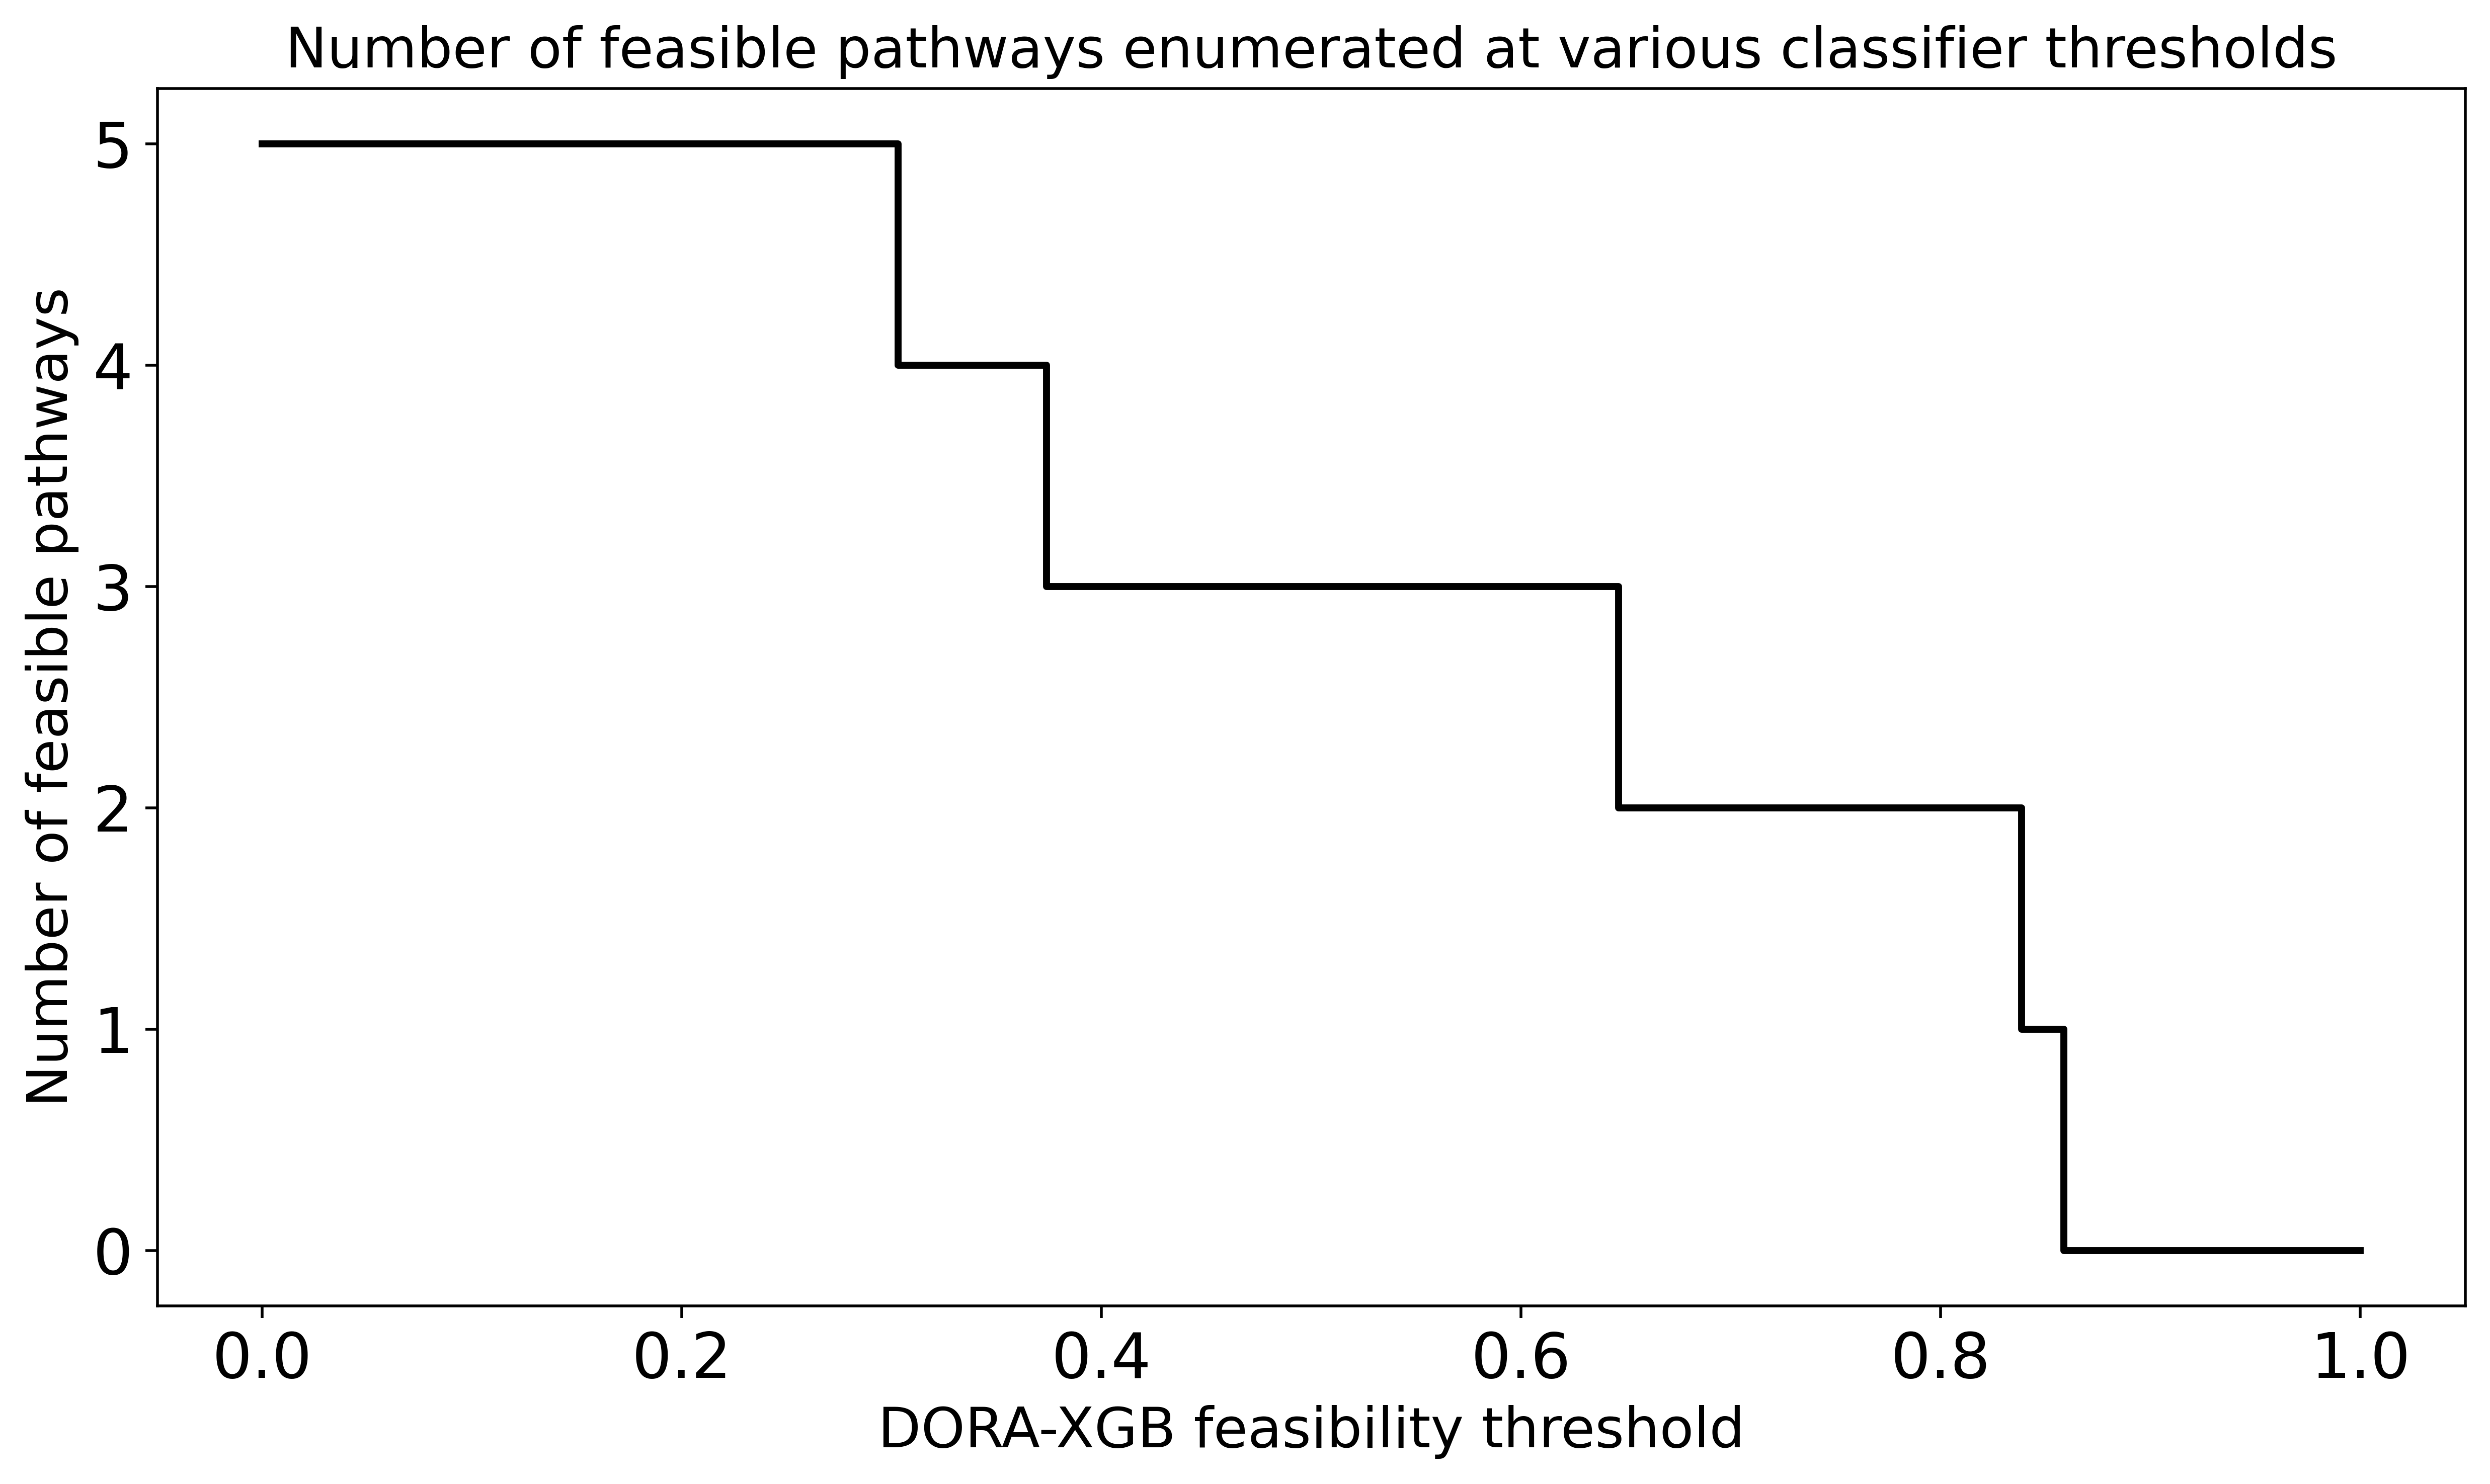

In [30]:
# Define thresholds
thresholds = np.linspace(0, 1, 100)

# Calculate the number of feasible pathways for each threshold
num_feasible_pathways = [sum(score >= threshold for score in net_feasibility_scores) for threshold in thresholds]

plt.figure(figsize=(10, 6))
plt.step(thresholds, num_feasible_pathways, where='post', color='black')
plt.xlabel('DORA-XGB feasibility threshold', fontsize = 16)
plt.ylabel('Number of feasible pathways', fontsize = 16)
plt.title('Number of feasible pathways enumerated at various classifier thresholds', fontsize = 16)
plt.savefig('main_fig6C')
plt.show()

### E coli metabolomics reactions

In [31]:
all_pos_rxns_list = []

Reaction 1: Uridine + orthophosphate ↔ D-ribose 1-phosphate + uracil (from conserved protein b0391, yaiE) (table 06, mapped rule: rule0099)

In [32]:
rxn_str = 'C1=CN(C(=O)NC1=O)C2C(C(C(O2)CO)O)O + OP(O)(O)=O = C(C1C(C(C(O1)OP(=O)(O)O)O)O)O + C1=CNC(=O)NC1=O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 1':
            {'Substrates': ['C1=CN(C(=O)NC1=O)C2C(C(C(O2)CO)O)O'],
             'lhs_cofactors': ['OP(O)(O)=O'],
             'Products': ['C(C1C(C(C(O1)OP(=O)(O)O)O)O)O','C1=CNC(=O)NC1=O'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0099'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 1'])

Feasibility score with descending MW model:  0.980, predicted label: 1
Feasibility score with ascending MW model:  0.995, predicted label: 1
Feasibility score with add concat model:  0.942, predicted label: 1
Feasibility score with add subtract model:  0.957, predicted label: 1


Reaction 2: Adenosine + orthophosphate ↔ D-ribose 1-phosphate + adenine (from conserved protein b0391, yaiE) (mapped rule: rule0099)

In [33]:
rxn_str = 'C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)CO)O)O)N + OP(O)(O)=O = C(C1C(C(C(O1)OP(=O)(O)O)O)O)O + C1=NC2=NC=NC(=C2N1)N'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 2':
            {'Substrates': ['C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)CO)O)O)N'],
             'lhs_cofactors': ['OP(O)(O)=O'],
             'Products': ['C(C1C(C(C(O1)OP(=O)(O)O)O)O)O','C1=NC2=NC=NC(=C2N1)N'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0099'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 2'])

Feasibility score with descending MW model:  0.999, predicted label: 1
Feasibility score with ascending MW model:  1.000, predicted label: 1
Feasibility score with add concat model:  0.999, predicted label: 1
Feasibility score with add subtract model:  1.000, predicted label: 1


Reaction 3: Guanosine + orthophosphate ↔ D-ribose 1-phosphate + guanine (from conserved protein b0391, yaiE) (mapped rule: rule0099)

In [34]:
rxn_str = 'C1=NC2=C(N1C3C(C(C(O3)CO)O)O)N=C(NC2=O)N + OP(O)(O)=O = C(C1C(C(C(O1)OP(=O)(O)O)O)O)O + C1=NC2=C(N1)C(=O)NC(=N2)N'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 3':
            {'Substrates': ['C1=NC2=C(N1C3C(C(C(O3)CO)O)O)N=C(NC2=O)N'],
             'lhs_cofactors': ['OP(O)(O)=O'],
             'Products': ['C(C1C(C(C(O1)OP(=O)(O)O)O)O)O','C1=NC2=C(N1)C(=O)NC(=N2)N'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0099'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 3'])

Feasibility score with descending MW model:  0.994, predicted label: 1
Feasibility score with ascending MW model:  0.991, predicted label: 1
Feasibility score with add concat model:  0.998, predicted label: 1
Feasibility score with add subtract model:  0.994, predicted label: 1


Reaction 4: Cytidine + orthophosphate ↔ D-ribose 1-phosphate + cytosine (from conserved protein b0391, yaiE) (mapped rule: rule0099)

In [35]:
rxn_str = 'C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O + OP(O)(O)=O = C(C1C(C(C(O1)OP(=O)(O)O)O)O)O + C1=C(NC(=O)N=C1)N'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 4':
            {'Substrates': ['C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O'],
             'lhs_cofactors': ['OP(O)(O)=O'],
             'Products': ['C(C1C(C(C(O1)OP(=O)(O)O)O)O)O','C1=C(NC(=O)N=C1)N'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0099'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 4'])

Feasibility score with descending MW model:  0.980, predicted label: 1
Feasibility score with ascending MW model:  0.999, predicted label: 1
Feasibility score with add concat model:  0.981, predicted label: 1
Feasibility score with add subtract model:  0.990, predicted label: 1


Reaction 5: Thymidine + orthophosphate ↔ D-ribose 1-phosphate + thymine (from conserved protein b0391, yaiE) (mapped rule: rule0099)

In [36]:
rxn_str = 'CC1=CN(C(=O)NC1=O)C2CC(C(O2)CO)O + OP(O)(O)=O = C(C1C(C(C(O1)OP(=O)(O)O)O)O)O + CC1=CNC(=O)NC1=O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 5':
            {'Substrates': ['CC1=CN(C(=O)NC1=O)C2CC(C(O2)CO)O'],
             'lhs_cofactors': ['OP(O)(O)=O'],
             'Products': ['C(C1C(C(C(O1)OP(=O)(O)O)O)O)O','CC1=CNC(=O)NC1=O'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0099'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 5'])

Feasibility score with descending MW model:  0.995, predicted label: 1
Feasibility score with ascending MW model:  0.999, predicted label: 1
Feasibility score with add concat model:  0.997, predicted label: 1
Feasibility score with add subtract model:  0.902, predicted label: 1


Reaction 6: Inosine + orthophosphate ↔ D-ribose 1-phosphate + hypoxanthine (from conserved protein b0391, yaiE) (mapped rule: rule0099)

In [37]:
rxn_str = 'C1=NC2=C(C(=O)N1)N=CN2C3C(C(C(O3)CO)O)O + OP(O)(O)=O = C(C1C(C(C(O1)OP(=O)(O)O)O)O)O + C1=NC2=C(N1)C(=O)NC=N2'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 6':
            {'Substrates': ['C1=NC2=C(C(=O)N1)N=CN2C3C(C(C(O3)CO)O)O'],
             'lhs_cofactors': ['OP(O)(O)=O'],
             'Products': ['C(C1C(C(C(O1)OP(=O)(O)O)O)O)O','C1=NC2=C(N1)C(=O)NC=N2'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0099'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 6'])

Feasibility score with descending MW model:  0.996, predicted label: 1
Feasibility score with ascending MW model:  0.997, predicted label: 1
Feasibility score with add concat model:  0.998, predicted label: 1
Feasibility score with add subtract model:  0.997, predicted label: 1


Reaction 7: Xanthosine + orthophosphate ↔ D-ribose 1-phosphate + xanthine (from conserved protein b0391, yaiE) (mapped rule: rule0099)

In [38]:
rxn_str = 'C1=NC2=C(N1C3C(C(C(O3)CO)O)O)NC(=O)NC2=O + OP(O)(O)=O = C(C1C(C(C(O1)OP(=O)(O)O)O)O)O + C1=NC2=C(N1)C(=O)NC(=O)N2'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 7':
            {'Substrates': ['C1=NC2=C(N1C3C(C(C(O3)CO)O)O)NC(=O)NC2=O'],
             'lhs_cofactors': ['OP(O)(O)=O'],
             'Products': ['C(C1C(C(C(O1)OP(=O)(O)O)O)O)O','C1=NC2=C(N1)C(=O)NC(=O)N2'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0099'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 7'])

Feasibility score with descending MW model:  0.886, predicted label: 1
Feasibility score with ascending MW model:  0.668, predicted label: 1
Feasibility score with add concat model:  0.994, predicted label: 1
Feasibility score with add subtract model:  0.819, predicted label: 1


Reaction 8: 2-oxobutanoate + NADPH → 2-hydroxybutanoate + NADP(+) (from predicted oxidoreductase b0599, ybdH) (mapped rule: rule0003, table 08)

In [39]:
rxn_str = 'CCC(C(O)=O)=O + NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1 + CCC(O)C(O)=O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 8':
            {'Substrates': ['CCC(C(O)=O)=O'],
             'lhs_cofactors': ['NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1'],
             'Products': ['CCC(O)C(O)=O'],
             'rhs_cofactors': ['NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0003'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 8'])

Feasibility score with descending MW model:  0.613, predicted label: 1
Feasibility score with ascending MW model:  0.992, predicted label: 1
Feasibility score with add concat model:  0.983, predicted label: 1
Feasibility score with add subtract model:  0.987, predicted label: 1


Reaction 9: 2-oxoglutarate + NADPH → 2-hydroxyglutarate + NADP(+) (from predicted oxidoreductase b0599, ybdH) (mapped rule: rule0003, table 08)

In [40]:
rxn_str = 'C(CC(=O)O)C(=O)C(=O)O + NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1 + C(CC(=O)O)C(C(=O)O)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 9':
            {'Substrates': ['C(CC(=O)O)C(=O)C(=O)O'],
             'lhs_cofactors': ['NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1'],
             'Products': ['C(CC(=O)O)C(C(=O)O)O'],
             'rhs_cofactors': ['NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0003'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 9'])

Feasibility score with descending MW model:  0.504, predicted label: 0
Feasibility score with ascending MW model:  0.881, predicted label: 1
Feasibility score with add concat model:  0.983, predicted label: 1
Feasibility score with add subtract model:  0.999, predicted label: 1


Reaction 10: 2-oxoglutarate + NADH + H+ → 2-hydroxyglutarate + NAD(+) (from predicted dehydrogenase b0801, yiC) (mapped rule: rule0003, table 08)

In [41]:
rxn_str = 'C(CC(=O)O)C(=O)C(=O)O + NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 + C(CC(=O)O)C(C(=O)O)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 10':
            {'Substrates': ['C(CC(=O)O)C(=O)C(=O)O'],
             'lhs_cofactors': ['NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1'],
             'Products': ['C(CC(=O)O)C(C(=O)O)O'],
             'rhs_cofactors': ['NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0003'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 10'])

Feasibility score with descending MW model:  0.960, predicted label: 1
Feasibility score with ascending MW model:  0.818, predicted label: 1
Feasibility score with add concat model:  0.918, predicted label: 1
Feasibility score with add subtract model:  0.999, predicted label: 1


Reaction 11 is a repeat of reaction 9

Reaction 12: Phenylpyruvate + NADH → phenyllactate + NAD(+) (from predicted dehydrogenase b0801, yiC) (table 06, mapped rule: rule0003, table08)

In [42]:
rxn_str = 'C1=CC=C(C=C1)CC(=O)C(=O)O + NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 + C1=CC=C(C=C1)CC(C(=O)O)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 11': # number 11 since one duplicate encountered so far
            {'Substrates': ['C1=CC=C(C=C1)CC(=O)C(=O)O'],
             'lhs_cofactors': ['NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1'],
             'Products': ['C1=CC=C(C=C1)CC(C(=O)O)O'],
             'rhs_cofactors': ['NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0003'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 11'])

Feasibility score with descending MW model:  0.966, predicted label: 1
Feasibility score with ascending MW model:  0.989, predicted label: 1
Feasibility score with add concat model:  0.885, predicted label: 1
Feasibility score with add subtract model:  0.979, predicted label: 1


Reaction 13: Phenylpyruvate + NADPH → phenyllactate + NADP(+) (from predicted dehydrogenase b0801, yiC) (mapped rule: rule0003, table 06, rule0003)

In [43]:
rxn_str = 'C1=CC=C(C=C1)CC(=O)C(=O)O + NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1 + C1=CC=C(C=C1)CC(C(=O)O)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 12': # number 12 since one duplicate encountered so far
            {'Substrates': ['C1=CC=C(C=C1)CC(=O)C(=O)O'],
             'lhs_cofactors': ['NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1'],
             'Products': ['C1=CC=C(C=C1)CC(C(=O)O)O'],
             'rhs_cofactors': ['NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0003'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 12'])

Feasibility score with descending MW model:  0.652, predicted label: 1
Feasibility score with ascending MW model:  0.992, predicted label: 1
Feasibility score with add concat model:  0.958, predicted label: 1
Feasibility score with add subtract model:  0.986, predicted label: 1


Reaction 14: 3-(4-hydroxyphenyl)pyruvate + NADH → 3-(4-hydroxyphenyl)lactate + NAD(+) (from predicted dehydrogenase b0801, yiC) (mapped rule: rule0003)

In [44]:
rxn_str = 'O=C(C(O)=O)CC1=CC=C(O)C=C1 + NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 + O=C(O)C(O)CC1=CC=C(O)C=C1'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 13': # number 13 since one duplicate encountered so far
            {'Substrates': ['C1=CC=C(C=C1)CC(=O)C(=O)O'],
             'lhs_cofactors': ['NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1'],
             'Products': ['C1=CC=C(C=C1)CC(C(=O)O)O'],
             'rhs_cofactors': ['NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0003'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 13'])

Feasibility score with descending MW model:  0.930, predicted label: 1
Feasibility score with ascending MW model:  0.992, predicted label: 1
Feasibility score with add concat model:  0.920, predicted label: 1
Feasibility score with add subtract model:  0.979, predicted label: 1


Reaction 15: 3-(4-hydroxyphenyl)pyruvate + NADPH → 3-(4-hydroxyphenyl)lactate + NADP(+) (from predicted dehydrogenase b0801, yiC) (mapped rule: rule0003)

In [45]:
rxn_str = 'O=C(C(O)=O)CC1=CC=C(O)C=C1 + NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1 + O=C(O)C(O)CC1=CC=C(O)C=C1'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 14': # number 14 since one duplicate encountered so far
            {'Substrates': ['O=C(C(O)=O)CC1=CC=C(O)C=C1'],
             'lhs_cofactors': ['NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1'],
             'Products': ['O=C(O)C(O)CC1=CC=C(O)C=C1'],
             'rhs_cofactors': ['NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0003'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 14'])

Feasibility score with descending MW model:  0.465, predicted label: 0
Feasibility score with ascending MW model:  0.994, predicted label: 1
Feasibility score with add concat model:  0.977, predicted label: 1
Feasibility score with add subtract model:  0.986, predicted label: 1


Reaction 16: 4-pyridoxial + NADH → 4-pyridoxine + NAD(+) (from predicted oxidoreductase b1406, ydbC) (mapped rule: rule0003)

In [46]:
rxn_str = 'OCC1=C(C=O)C(O)=C(C)N=C1 + NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 + OCC1=C(CO)C(O)=C(C)N=C1'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 15': # number 15 since one duplicate encountered so far
            {'Substrates': ['OCC1=C(C=O)C(O)=C(C)N=C1'],
             'lhs_cofactors': ['NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1'],
             'Products': ['OCC1=C(CO)C(O)=C(C)N=C1'],
             'rhs_cofactors': ['NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0003'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 15'])

Feasibility score with descending MW model:  0.814, predicted label: 1
Feasibility score with ascending MW model:  0.992, predicted label: 1
Feasibility score with add concat model:  0.954, predicted label: 1
Feasibility score with add subtract model:  0.992, predicted label: 1


Reaction 17: 4-pyridoxial + NADPH → 4-pyridoxine + NADP(+) (from predicted oxidoreductase b1406, ydbC) (mapped rule: rule0003)

In [47]:
rxn_str = 'OCC1=C(C=O)C(O)=C(C)N=C1 + NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1 = NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1 + OCC1=C(CO)C(O)=C(C)N=C1'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 16': # number 16 since one duplicate encountered so far
            {'Substrates': ['OCC1=C(C=O)C(O)=C(C)N=C1'],
             'lhs_cofactors': ['NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1'],
             'Products': ['OCC1=C(CO)C(O)=C(C)N=C1'],
             'rhs_cofactors': ['NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0003'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 16'])

Feasibility score with descending MW model:  0.295, predicted label: 0
Feasibility score with ascending MW model:  0.999, predicted label: 1
Feasibility score with add concat model:  0.982, predicted label: 1
Feasibility score with add subtract model:  0.992, predicted label: 1


Reaction 18: fumarate + H2O → malate (from predicted protein b1675, ydhZ) (mapped rule: rule0035)

In [48]:
rxn_str = 'O=C(O)C=CC(O)=O + O = C(C(C(=O)O)O)C(=O)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 17': # number 17 since one duplicate encountered so far
            {'Substrates': ['O=C(O)C=CC(O)=O'],
             'lhs_cofactors': ['O'],
             'Products': ['C(C(C(=O)O)O)C(=O)O'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0035'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 17'])

Feasibility score with descending MW model:  0.508, predicted label: 0
Feasibility score with ascending MW model:  0.955, predicted label: 1
Feasibility score with add concat model:  0.637, predicted label: 1
Feasibility score with add subtract model:  0.868, predicted label: 1


Reaction 19: D-sorbitol 6-phosphate + H2O → D-sorbitol + orthophosphate (from sugar phosphatase b2293, yfbT) (mapped rule: rule0007)

In [49]:
rxn_str = 'C(C(C(C(C(COP(=O)(O)O)O)O)O)O)O + O = C(C(C(C(C(CO)O)O)O)O)O + OP(O)(O)=O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 18': # number 18 since one duplicate encountered so far
            {'Substrates': ['C(C(C(C(C(COP(=O)(O)O)O)O)O)O)O'],
             'lhs_cofactors': ['O'],
             'Products': ['C(C(C(C(C(CO)O)O)O)O)O','OP(O)(O)=O'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0007'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 18'])

Feasibility score with descending MW model:  0.997, predicted label: 1
Feasibility score with ascending MW model:  1.000, predicted label: 1
Feasibility score with add concat model:  0.994, predicted label: 1
Feasibility score with add subtract model:  0.991, predicted label: 1


Reaction 20: D-mannitol 1-phosphate + H2O → D-mannitol + orthophosphate (from sugar phosphatase b2293, yfbT) (mapped rule: rule0007)

In [50]:
rxn_str = 'C(C(C(C(C(COP(=O)(O)O)O)O)O)O)O + O = C(C(C(C(C(CO)O)O)O)O)O + OP(O)(O)=O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 19': # number 19 since one duplicate encountered so far
            {'Substrates': ['C(C(C(C(C(COP(=O)(O)O)O)O)O)O)O'],
             'lhs_cofactors': ['O'],
             'Products': ['C(C(C(C(C(CO)O)O)O)O)O','OP(O)(O)=O'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0007'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 19'])

Feasibility score with descending MW model:  0.997, predicted label: 1
Feasibility score with ascending MW model:  1.000, predicted label: 1
Feasibility score with add concat model:  0.994, predicted label: 1
Feasibility score with add subtract model:  0.991, predicted label: 1


Reaction 21: adenosine 5′-monophosphate + H2O → adenine + D-ribose 5′-phosphate (from conserved protein, UPF0053 family) (mapped rule: rule0007)

In [51]:
rxn_str = 'C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)O)O)O)N + O = C1=NC2=NC=NC(=C2N1)N + C(C(C(C(C=O)O)O)O)OP(=O)(O)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 20': # number 20 since one duplicate encountered so far
            {'Substrates': ['C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)O)O)O)N'],
             'lhs_cofactors': ['O'],
             'Products': ['C1=NC2=NC=NC(=C2N1)N','C(C(C(C(C=O)O)O)O)OP(=O)(O)O'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0007'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 20'])

Feasibility score with descending MW model:  0.934, predicted label: 1
Feasibility score with ascending MW model:  0.999, predicted label: 1
Feasibility score with add concat model:  0.484, predicted label: 0
Feasibility score with add subtract model:  0.985, predicted label: 1


Reaction 22: guanosine 5′-monophosphate + H2O → guanine + D-ribose 5′-phosphate (from conserved protein, UPF0053 family) (mapped rule: rule0007)

In [52]:
rxn_str = 'C1=NC2=C(N1C3C(C(C(O3)COP(=O)(O)O)O)O)N=C(NC2=O)N + O = C1=NC2=C(N1)C(=O)NC(=N2)N + C(C(C(C(C=O)O)O)O)OP(=O)(O)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 21': # number 21 since one duplicate encountered so far
            {'Substrates': ['C1=NC2=C(N1C3C(C(C(O3)COP(=O)(O)O)O)O)N=C(NC2=O)N'],
             'lhs_cofactors': ['O'],
             'Products': ['C1=NC2=C(N1)C(=O)NC(=N2)N','C(C(C(C(C=O)O)O)O)OP(=O)(O)O'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0007'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 21'])

Feasibility score with descending MW model:  0.941, predicted label: 1
Feasibility score with ascending MW model:  0.917, predicted label: 1
Feasibility score with add concat model:  0.843, predicted label: 1
Feasibility score with add subtract model:  0.992, predicted label: 1


Reaction 23: inosine 5′-monophosphate + H2O → hypoxanthine + D-ribose 5′-phosphate (from conserved protein, UPF0053 family) (mapped rule: rule0007)

In [53]:
rxn_str = 'C1=NC2=C(C(=O)N1)N=CN2C3C(C(C(O3)COP(=O)(O)O)O)O + O = C1=NC2=C(N1)C(=O)NC=N2 + C(C(C(C(C=O)O)O)O)OP(=O)(O)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 22': # number 22 since one duplicate encountered so far
            {'Substrates': ['C1=NC2=C(C(=O)N1)N=CN2C3C(C(C(O3)COP(=O)(O)O)O)O'],
             'lhs_cofactors': ['O'],
             'Products': ['C1=NC2=C(N1)C(=O)NC=N2','C(C(C(C(C=O)O)O)O)OP(=O)(O)O'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0007'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 22'])

Feasibility score with descending MW model:  0.983, predicted label: 1
Feasibility score with ascending MW model:  0.945, predicted label: 1
Feasibility score with add concat model:  0.741, predicted label: 1
Feasibility score with add subtract model:  0.992, predicted label: 1


Reaction 24: Cytidine 5′-monophosphate + H2O → cytosine + D-ribose 5′-phosphate (from conserved protein, UPF0053 family) (mapped rule: rule0007)

In [54]:
rxn_str = 'C1=CN(C(=O)N=C1N)C2C(C(C(O2)COP(=O)(O)O)O)O + O = C1=C(NC(=O)N=C1)N + C(C(C(C(C=O)O)O)O)OP(=O)(O)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 23': # number 23 since one duplicate encountered so far
            {'Substrates': ['C1=CN(C(=O)N=C1N)C2C(C(C(O2)COP(=O)(O)O)O)O'],
             'lhs_cofactors': ['O'],
             'Products': ['C1=C(NC(=O)N=C1)N','C(C(C(C(C=O)O)O)O)OP(=O)(O)O'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0007'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 23'])

Feasibility score with descending MW model:  0.873, predicted label: 1
Feasibility score with ascending MW model:  0.972, predicted label: 1
Feasibility score with add concat model:  0.587, predicted label: 0
Feasibility score with add subtract model:  0.992, predicted label: 1


Reaction 25: 2-deoxythymidine 5′-monophosphate + H2O → thymine + 2-deoxy-D-ribose 5′-phosphate (from conserved protein, UPF0053 family) (mapped rule: rule0007)

In [55]:
rxn_str = 'CC1=CN(C(=O)NC1=O)C2CC(C(O2)COP(=O)(O)O)O + O = CC1=CNC(=O)NC1=O + C(C(C(C(C=O)O)O)O)OP(=O)(O)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 24': # number 24 since one duplicate encountered so far
            {'Substrates': ['CC1=CN(C(=O)NC1=O)C2CC(C(O2)COP(=O)(O)O)O'],
             'lhs_cofactors': ['O'],
             'Products': ['CC1=CNC(=O)NC1=O','C(C(C(C(C=O)O)O)O)OP(=O)(O)O'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0007'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 24'])

Feasibility score with descending MW model:  0.881, predicted label: 1
Feasibility score with ascending MW model:  0.948, predicted label: 1
Feasibility score with add concat model:  0.917, predicted label: 1
Feasibility score with add subtract model:  0.832, predicted label: 1


Reaction 26: Uridine 5′-monophosphate + H2O → uracil + D-ribose 5′-phosphate (from conserved protein, UPF0053 family) (mapped rule: rule00007)

In [56]:
rxn_str = 'C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)(O)O)O)O + O = C1=CNC(=O)NC1=O + C(C(C(C(C=O)O)O)O)OP(=O)(O)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 25': # number 25 since one duplicate encountered so far
            {'Substrates': ['C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)(O)O)O)O'],
             'lhs_cofactors': ['O'],
             'Products': ['C1=CNC(=O)NC1=O','C(C(C(C(C=O)O)O)O)OP(=O)(O)O'],
             'rhs_cofactors': [],
             'Reaction eq': rxn_str,
             'Rule': 'rule0007'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 25'])

Feasibility score with descending MW model:  0.718, predicted label: 1
Feasibility score with ascending MW model:  0.741, predicted label: 1
Feasibility score with add concat model:  0.684, predicted label: 1
Feasibility score with add subtract model:  0.994, predicted label: 1


Reaction 27 is a repeat of reaction 18

Reaction 28: Uridine 5′-triphosphate + H2O → uridine 5′-monophosphate + pyrophosphate (rule1200)

In [57]:
rxn_str = 'C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O)O + O = C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)(O)O)O)O + O=P(O)(OP(O)=O)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 26': # number 26 since two duplicates encountered so far
            {'Substrates': ['C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O)O'],
             'lhs_cofactors': ['O'],
             'Products': ['C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)(O)O)O)O'],
             'rhs_cofactors': ['O=P(O)(OP(O)=O)O'],
             'Reaction eq': rxn_str,
             'Rule': 'rule1200'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 26'])

Feasibility score with descending MW model:  0.993, predicted label: 1
Feasibility score with ascending MW model:  0.918, predicted label: 1
Feasibility score with add concat model:  0.694, predicted label: 1
Feasibility score with add subtract model:  0.818, predicted label: 1


Reaction 29: L-phenylalanine + acetyl-CoA → N-acetyl-L-phenylalanine + coenzyme A (from predicted acetyltransferase, b3441, yhhY) (mapped rule: rule0042, this is indeed a new enzyme: look at publications under https://www.uniprot.org/uniprotkb/P46854/entry)

In [58]:
rxn_str = 'C1=CC=C(C=C1)CC(C(=O)O)N + CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O = CC(=O)NC(CC1=CC=CC=C1)C(=O)O + CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCS)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 27': # number 27 since two duplicates encountered so far
            {'Substrates': ['C1=CC=C(C=C1)CC(C(=O)O)N'],
             'lhs_cofactors': ['CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O'],
             'Products': ['CC(=O)NC(CC1=CC=CC=C1)C(=O)O'],
             'rhs_cofactors': ['CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCS)O'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0042'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 27'])

Feasibility score with descending MW model:  0.999, predicted label: 1
Feasibility score with ascending MW model:  0.998, predicted label: 1
Feasibility score with add concat model:  0.995, predicted label: 1
Feasibility score with add subtract model:  0.998, predicted label: 1


Reaction 30: L-methionine + acetyl-CoA → N-acetyl-L-methionine + coenzyme A (from predicted acetyltransferase, b3441, yhhY) (no metacyc entry, mapped rule: rule0042)

In [59]:
rxn_str = 'CSCCC(C(=O)O)N + CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O = CC(=O)NC(CCSC)C(=O)O + CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCS)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 28': # number 28 since two duplicates encountered so far
            {'Substrates': ['CSCCC(C(=O)O)N'],
             'lhs_cofactors': ['CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O'],
             'Products': ['CC(=O)NC(CCSC)C(=O)O'],
             'rhs_cofactors': ['CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCS)O'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0042'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 28'])

Feasibility score with descending MW model:  0.998, predicted label: 1
Feasibility score with ascending MW model:  0.996, predicted label: 1
Feasibility score with add concat model:  0.957, predicted label: 1
Feasibility score with add subtract model:  0.988, predicted label: 1


Reaction 31 is a repeat of reaction 30

Reaction 32: L-methionine + propionyl-CoA → N-propionyl-L-methionine + coenzyme A (no metacyc entry, mapped rule: rule0042 - even though this uses acetyl-CoA)

In [60]:
rxn_str = 'CSCCC(C(=O)O)N + CCC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O = CCC(=O)NC(CCSC)C(=O)O + CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCS)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 29': # number 29 since three duplicates encountered so far
            {'Substrates': ['CSCCC(C(=O)O)N'],
             'lhs_cofactors': ['CCC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O'],
             'Products': ['CCC(=O)NC(CCSC)C(=O)O'],
             'rhs_cofactors': ['CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCS)O'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0042'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 29'])

Feasibility score with descending MW model:  1.000, predicted label: 1
Feasibility score with ascending MW model:  0.999, predicted label: 1
Feasibility score with add concat model:  0.967, predicted label: 1
Feasibility score with add subtract model:  0.993, predicted label: 1


Reaction 33: L-phenylglycine + acetyl-CoA → N-acetyl-L-phenylglycine + coenzyme A (no metacyc entry, mapped rule: rule0042))

In [61]:
rxn_str = 'C1=CC=C(C=C1)C(C(=O)O)N + CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O = CC(=O)NC(C1=CC=CC=C1)C(=O)O + CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCS)O'
calculate_proba(rxn_str, all_cofactors_wo_stereo)

rxn_dict = {'E coli reaction 30': # number 30 since three duplicates encountered so far
            {'Substrates': ['C1=CC=C(C=C1)C(C(=O)O)N'],
             'lhs_cofactors': ['CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O'],
             'Products': ['CC(=O)NC(C1=CC=CC=C1)C(=O)O'],
             'rhs_cofactors': ['CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)C(C(=O)NCCC(=O)NCCS)O'],
             'Reaction eq': rxn_str,
             'Rule': 'rule0042'}}

all_pos_rxns_list.append(rxn_dict['E coli reaction 30'])

Feasibility score with descending MW model:  0.997, predicted label: 1
Feasibility score with ascending MW model:  0.999, predicted label: 1
Feasibility score with add concat model:  0.985, predicted label: 1
Feasibility score with add subtract model:  0.959, predicted label: 1


Reaction 34 is a repeat of reaction 19

Reaction 35 is a repeat of reaction 20

#### filtering out pathways and compounds

In [62]:
import json
with open('../../data/processed/pickaxe_pyruvate_propionate_3gen_updated.json') as f:
    pyruvate_pickaxe_json = json.loads(f.read())
    
pyruvate_smiles = 'CC(=O)C(=O)O'
acrylate_smiles = 'C=CC(=O)O'

In [63]:
pyruvate_graph = nx.DiGraph()

for i_rxn, rxn in enumerate(sorted(pyruvate_pickaxe_json)):
    
    if not i_rxn % 10000:
        print(i_rxn)
    
    temp_smiles0, temp_smiles1 = rxn.split('>>')   
    temp_rule, temp_score = pyruvate_pickaxe_json[rxn]
    
    pyruvate_graph.add_edge(temp_smiles0, temp_smiles1, rule=temp_rule, score=float(temp_score))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000


In [64]:
def number_predicted_pathways(cutoff):

    # trim graph with reactions satisfying cutoff threshold
    cutoff_graph = copy.deepcopy(pyruvate_graph)

    for edge in pyruvate_graph.edges:
        if pyruvate_graph[edge[0]][edge[1]]['score'] < cutoff:
            cutoff_graph.remove_edge(edge[0], edge[1])

    no_gen = 3
    rxn_dict = {g: set() for g in range(1 + no_gen)}
    cpd_dict = {g: set() for g in range(1 + no_gen)}
    cpd_dict[0] = {pyruvate_smiles}

    for edges in nx.edge_bfs(cutoff_graph, source=pyruvate_smiles, orientation='original'):

        node_0, node_1, _ = edges
        gen_0 = [k for k, v in cpd_dict.items() if node_0 in v][0]

        if gen_0 >= no_gen:
            break

        cpd_dict[gen_0 + 1].update({node_1})
        rxn_dict[gen_0 + 1].update({(node_0, node_1)})

    no_cpds = [len(cpd_dict[1 + g]) for g in range(no_gen)]
    no_rxns = [len(rxn_dict[1 + g]) for g in range(no_gen)]

    return no_cpds, no_rxns

In [65]:
def number_candidate_pathways(cutoff):
    
    pathway_graph = nx.DiGraph()
    
    pathway_graph.add_node(pyruvate_smiles)
    pathway_graph.add_node(acrylate_smiles)
    
    for rxn_id, temp_smiles in processed_dict.items():
        if cutoff <= score_dict[rxn_id]:
            pathway_graph.add_edge(temp_smiles[0][0], temp_smiles[1][0])

    return len(list(nx.all_simple_paths(pathway_graph, pyruvate_smiles, acrylate_smiles)))

In [66]:
plot_x = np.arange(0, 1, 0.01)
temp_plot = [number_predicted_pathways(p) for p in plot_x]
plot_cpds = [t[0] for t in temp_plot]
plot_rxns = [t[1] for t in temp_plot]

In [67]:
plt.rcParams['text.usetex'] = False


In [68]:
fig, ax = plt.subplots(figsize=(28, 17))

plt.plot(plot_x, [p[0] for p in plot_cpds], color='#66c2a5', linewidth=10)
plt.plot(plot_x, [p[1] for p in plot_cpds], color='#fc8d62', linewidth=10)
plt.plot(plot_x, [p[2] for p in plot_cpds], color='#8da0cb', linewidth=10)

ax.set_yscale('log')
plt.xlim([-0.05, 1.05])
plt.xticks(np.arange(0, 1.01, 0.1))
plt.ylim([0.6, 3000000])

ax.xaxis.set_tick_params(width=5, length=10)
ax.yaxis.set_tick_params(width=5, length=10)
ax.tick_params(axis='both', which='major', labelsize=32)
[x.set_linewidth(3) for x in ax.spines.values()]

ax.set_xlabel('Classifier Threshold', fontsize=66)
ax.set_ylabel('Number of New $\it{Compounds}$\nin Each Generation', fontsize=66)
plt.legend(['1st Generation', '2nd Generation', '3rd Generation'], fontsize=32)

plt.savefig('main_fig7A.png')
plt.show()

In [69]:
fig, ax = plt.subplots(figsize=(28, 17))

plt.plot(plot_x, [p[0] for p in plot_rxns], color='#66c2a5', linewidth=10)
plt.plot(plot_x, [p[1] for p in plot_rxns], color='#fc8d62', linewidth=10)
plt.plot(plot_x, [p[2] for p in plot_rxns], color='#8da0cb', linewidth=10)

ax.set_yscale('log')
plt.xlim([-0.05, 1.05])
plt.xticks(np.arange(0, 1.01, 0.1))
plt.ylim([0.6, 3000000])

ax.xaxis.set_tick_params(width=5, length=10)
ax.yaxis.set_tick_params(width=5, length=10)
ax.tick_params(axis='both', which='major', labelsize=32)
[x.set_linewidth(3) for x in ax.spines.values()]

ax.set_xlabel('Classifier Threshold', fontsize=66)
ax.set_ylabel('Number of New $\it{Reactions}$\nin Each Generation', fontsize=66)
plt.legend(['1st Generation', '2nd Generation', '3rd Generation'], fontsize=32)

plt.savefig('main_fig7B.png')
plt.show()